# Avatar decoding example
#### Training a classifier to distinguish 6 non-speech articulatory movements in the articulatory-movement task

In [5]:
# Check if you have a GPU
!nvidia-smi
%load_ext autoreload
%autoreload 2

Fri Jun  2 21:24:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN V      Off  | 00000000:3B:00.0 Off |                  N/A |
| 28%   31C    P8    24W / 250W |   1815MiB / 12066MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA TITAN V      Off  | 00000000:5E:00.0 Off |                  N/A |
| 28%   

In [6]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = str(2)

In [7]:
# TODO - change this to be your own directory. 
data_dir= 'YOUR_DATA_DIR'

In [8]:
## Load up the helper functions 
import numpy as np
import argparse
import torch
from sklearn.model_selection import StratifiedKFold
parser = argparse.ArgumentParser()
parser.add_argument('--decimation', 
                   default=6, 
                   type=int, 
                   help='How much to decimate')
parser.add_argument('--start_time', 
                    type=float,
                   default=1,
                   help='how much time before cue')
parser.add_argument('--end_time',
                    type=float,
                   default=3, 
                   help= 'how much time after the cue')
parser.add_argument('--hidden_dim',
                    type=int,
                   default=512,
                   help="how many hid.units")
parser.add_argument('--lr', 
                    type=float,
                   default=1e-3,
                   help='learning rate')
parser.add_argument('--ks', 
                    type=int,
                   default=1,
                   help='ks at input.')
parser.add_argument('--num_layers',
                   type=int, 
                   default=2,
                   help='number of layers')
parser.add_argument('--dropout', 
                   type=float, 
                   default=0.6, 
                   help='dropout amount')
parser.add_argument('--feat_stream', 
                   type=str, 
                   default='both',
                   help='which stream. both, hga, or raw')
parser.add_argument('--bs',
                   type=int, 
                   default=32, 
                   help='batch size')
parser.add_argument('--smooth',
                   type=int,
                   default=10)
parser.add_argument('--no_normalize', 
                   action='store_false',
                   help='no keras normalisation')
parser.add_argument('--maxpool_ks', type=int, default=10,
                    help='how much to go')
args = vars(parser.parse_args( '--num_layers 1 --no_normalize'.split()))


In [9]:
from os.path import join
X = np.load(join(data_dir, 'X_avatar_pc.npy'))
Y = np.load(join(data_dir, 'Y_avatar_pc.npy'))

# The Y's correspond to the following avatar movements: 
# 0: Lips back
# 1: Lips forward
# 2: Mouth closed
# 3: Mouth open
# 4: Tongue down
# 5: Tongue up 

In [10]:
# Extract the features from the neural data
X_m = np.max(X[:, :62], axis=1)
X_n = np.min(X[:, :62], axis=1)
X_mu = np.mean(X[:, :62], axis=1)
X_s = np.std(X[:, :62], axis=1)
X_m2 = np.max(X[:, 62:], axis=1)
X_n2 = np.min(X[:, 62:], axis=1)
X_mu2 = np.mean(X[:, 62:], axis=1)
X_s2 = np.std(X[:, 62:], axis=1)

In [11]:
X_m.shape

(840, 506)

In [12]:
X_new = np.hstack((X_m, X_n, X_mu, X_s, X_m2, X_n2, X_mu2, X_s2))

In [13]:
X_new.shape

(840, 4048)

In [15]:
train = np.arange(760)
val = np.arange(760, 800)
test_final= np.arange(800, 840)

In [16]:
X_new.shape

(840, 4048)

In [17]:
from models import MLP # import a simple model!

/home/smetzger/.conda/envs/silent_spelling/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
best_hps = (0.6, 2, 512) # Hyperparameters used, 
# these were found via tuning using the final 40 samples as the hyperparameter tuning set, so we exclude those below. 

In [22]:
n_class = len(set(Y))
from collections import Counter
y_ct =dict(Counter(Y))
minct = np.inf
for k, v in y_ct.items():
    minct = min(minct, v)
print('minct', minct)
cv_accs = []
all_preds, all_gts = [], []

for state in range(1):
    skf = StratifiedKFold(10, shuffle=True, random_state=state)
    for cv, (train, val) in enumerate(skf.split(X[:800], Y[:800])):
#         print(len(train), len(test))

        X_s, X_val = X_new[train], X_new[val]
        Y_s, Y_val = Y[train], Y[val]
        skf2 = StratifiedKFold(9, shuffle=True, random_state=state)
        for train_final, test_final in skf2.split(X_s, Y_s):
            break
            
        for t in test_final: 
            assert not t in train_final
        train = train_final
        X_te = X_s[test_final]
        Y_te = Y_s[test_final]
        X_tr = X_s[train_final]
        Y_tr = Y_s[train_final]
  
        print('X_tr shape', X_tr.shape)
        print('X_te shape', X_te.shape)
        print('X_val shape', X_val.shape)
    #     break

        model = MLP(512, X_tr.shape[-1], len(set(Y)), 0.6, 2)

        import bravo_ml

        from bravo_ml.modelling.torch_trainers import train_classifier

        from torch.utils.data import DataLoader, TensorDataset
        import copy

        train_dset = TensorDataset(torch.from_numpy(X_tr.copy()), torch.from_numpy(Y_tr.copy()))
        test_dset = TensorDataset(torch.from_numpy(X_te.copy()), torch.from_numpy(Y_te.copy()))
        val_dset = TensorDataset(torch.from_numpy(X_val.copy()), torch.from_numpy(Y_val.copy()))

        train_loader = DataLoader(train_dset, batch_size=args['bs'], shuffle=True) 
        test_loader = DataLoader(test_dset, batch_size=args['bs'], shuffle=False)
        val_loader = DataLoader(val_dset, batch_size=args['bs'], shuffle=False)

        m, hist =train_classifier(model, train_loader,
                        val_loader, 
                        'cpu', 
                        patience=20, 
                         wandb_flag=False,
                        lr=args['lr'],
                                 es_metric='acc',
                                 checkpoint=True, 
                                 file_checkpoint=False)
        
        # Can save the model if you want using line below.
#         torch.save(m.state_dict(), './models/expressions/model_%d.pth' %cv)
        m, hist_final = train_classifier(m, 
                                        train_loader,
                                        test_loader,
                                        'cpu',
                                        patience=1,
                                        wandb_flag=False,
                                        lr=args['lr'], 
                                        run_training=False)
        
        with torch.no_grad():
            for x, y in test_loader:
                print(x.shape)
                preds = model(x.float())
                ml = preds.argmax(1).detach().cpu().numpy()
                all_preds.extend(ml)
                all_gts.extend(y.detach().cpu().numpy())
        cv_accs.append(np.max(hist_final['val_acc']))
    
# wandb.log({'cvaccs':cv_accs,
#           'meanacc':np.mean(cv_accs)})
    

minct 140
X_tr shape (640, 4048)
X_te shape (80, 4048)
X_val shape (80, 4048)
is 4048
epoch 0, loss: 1.620, te_loss: 1.381, acc: 0.369, te acc: 0.550
chk
epoch 1, loss: 1.171, te_loss: 1.025, acc: 0.619, te acc: 0.738
chk
epoch 2, loss: 0.853, te_loss: 0.766, acc: 0.747, te acc: 0.787
chk
epoch 3, loss: 0.640, te_loss: 0.597, acc: 0.836, te acc: 0.887
chk
epoch 4, loss: 0.481, te_loss: 0.494, acc: 0.889, te acc: 0.850
epoch 5, loss: 0.357, te_loss: 0.431, acc: 0.902, te acc: 0.863
epoch 6, loss: 0.299, te_loss: 0.355, acc: 0.919, te acc: 0.912
chk
epoch 7, loss: 0.229, te_loss: 0.326, acc: 0.958, te acc: 0.900
epoch 8, loss: 0.169, te_loss: 0.313, acc: 0.967, te acc: 0.900
epoch 9, loss: 0.147, te_loss: 0.314, acc: 0.972, te acc: 0.875
epoch 10, loss: 0.106, te_loss: 0.265, acc: 0.980, te acc: 0.875
epoch 11, loss: 0.085, te_loss: 0.279, acc: 0.986, te acc: 0.887
epoch 12, loss: 0.070, te_loss: 0.263, acc: 0.989, te acc: 0.875
epoch 13, loss: 0.055, te_loss: 0.215, acc: 0.997, te acc: 

In [23]:
np.mean(cv_accs)

0.8825

In [24]:
def bootstrap(x, B=2000, metric=np.median):
    dist = [metric(np.random.choice(x, size=len(x), replace=True)) for _ in range(B)]
    return dist

np.random.seed(1337)

def return_distribution(lom, metric=np.median):
    """
    Input : list of metrics - basically just like a list, we want to change it to be median and stuff. 
    """
    return bootstrap(lom, len(lom), metric)

In [25]:
print('%.2f' %(100*np.mean(cv_accs)), '99% CI', [np.round(k*100, 2) for k in np.percentile(bootstrap(cv_accs, metric=np.mean), [.5, 99.5])])

88.25 99% CI [85.88, 90.5]


In [26]:
len(all_preds)

800

In [27]:
best_hps

(0.6, 2, 512)

In [28]:
labels = ['Lips\nback', 'Lips\nforward',
 'Mouth\nclosed', 'Mouth\nopen',
 'Tongue\ndown' ,'Tongue\nup']

In [29]:
cm =np.zeros((len(labels), len(labels)))

In [30]:
labels

['Lips\nback',
 'Lips\nforward',
 'Mouth\nclosed',
 'Mouth\nopen',
 'Tongue\ndown',
 'Tongue\nup']

In [31]:
for k, (g,p) in enumerate(zip(all_gts, all_preds)):
    cm[g, p] +=1

In [32]:
import matplotlib.pyplot as plt

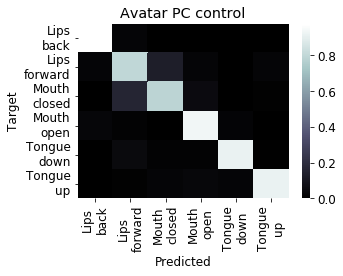

In [33]:
for k in range(cm.shape[0]):
    cm[k, :] = cm[k, :]/np.sum(cm[k, :])

import pandas as pd
import seaborn as sns
plt.figure(figsize=(5, 4))
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
sns.heatmap(pd.DataFrame(data=cm,columns=labels, index=labels), cmap='bone')
plt.xlabel('Predicted')
plt.ylabel('Target')
plt.title('Avatar PC control')
plt.tight_layout()
plt.savefig('./results/avatar_pc_cm.png', dpi=300)

In [34]:
df = pd.DataFrame(data=cm,columns=labels, index=labels)

In [35]:
df.to_hdf('./results/pc_cm.h5', key='df')